# Prediction du remboursement d'un pret

## Introduction

Lending Club est une société américaine de finance participative. C'est une plateforme de prêt entre particuliers qui permet aux clients emprunteurs d’avoir accès à des crédits à des taux plus bas que ceux proposés par les banques traditionnelles et permet aux clients investisseurs d’investir leurs épargnes sous forme de prêt.

Nous allons dans ce projet exploiter une base de donnée clientèle du Lending Club. Cette base de donnée contient l'ensemble des données relative aux prêts emis à travers la plateforme. L'ensemble des variables observées pour chaque individu sont détaillées dans le dictionnaire.

Source de la base donnée : 

https://www.kaggle.com/adarshsng/lending-club-loan-data-csv/version/1?select=loan.csv

In [ ]:
# import warnings
warnings.filterwarnings('ignore')

## Traitement de la base de donnée

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv("loan.csv")
data.shape

(2260668, 145)

Le dataset contient 2 260 668 individus et 145 colonnes dont la colonne d'intérêt. Nous allons filtrer les colonnes et nous recupererons que 200 000 individus pour les données d'entrainement et 10 000 pour les données de test.

Ensuite, étant donné que nous voulons etudier le statut de remboursement des clients, nous allons nous limiter aux catégories suivante de notre variable d'intérêt 'loan_status' :
- Fully Paid : Les personnes qui ont remboursé la totalité de leur crédit.
- Charged Off : Les personnes qui n’ont pas remboursé leur crédit.

In [3]:
variables_to_keep = ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
                     'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
                     'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'emp_length', 'home_ownership', 'purpose',
                     'loan_status']
data_filtered = data[variables_to_keep]
data_filtered = data_filtered[data_filtered['loan_status'].isin(['Charged Off', 'Fully Paid'])]

In [4]:
train_data = data_filtered[:200000]
test_data = data_filtered[200000:210000]

In [5]:
train_data.info() #affiche les noms des colonnes, le nombre des valeurs manquantes ainsi que leurs types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 100 to 743954
Data columns (total 19 columns):
loan_amnt                     200000 non-null int64
annual_inc                    200000 non-null float64
dti                           199870 non-null float64
delinq_2yrs                   200000 non-null float64
inq_last_6mths                200000 non-null float64
open_acc                      200000 non-null float64
pub_rec                       200000 non-null float64
revol_bal                     200000 non-null int64
revol_util                    199845 non-null float64
total_acc                     200000 non-null float64
collections_12_mths_ex_med    200000 non-null float64
acc_now_delinq                200000 non-null float64
tot_coll_amt                  200000 non-null float64
tot_cur_bal                   200000 non-null float64
total_rev_hi_lim              200000 non-null float64
emp_length                    186427 non-null object
home_ownership              

In [6]:
train_data.isnull().sum(axis = 0) #Comptabilise les valeurs manquantes pour chaque colonne

loan_amnt                         0
annual_inc                        0
dti                             130
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      155
total_acc                         0
collections_12_mths_ex_med        0
acc_now_delinq                    0
tot_coll_amt                      0
tot_cur_bal                       0
total_rev_hi_lim                  0
emp_length                    13573
home_ownership                    0
purpose                           0
loan_status                       0
dtype: int64

In [7]:
#Explorer la variable à prédire
train_data['loan_status'].value_counts() # "Value_count compte le nombre d'occurences des valeurs d'une colonne 

Fully Paid     153518
Charged Off     46482
Name: loan_status, dtype: int64

### Préprocessing

In [8]:
# Nous allons combiner le train et le test dataset afin que le preprocessing soit appliqué en même temps: l'objectif est de 
# concaténer les 2 fichiers en extrayant au préalable la variable 'loan status'.
def combined_data(train,test):
    target_train = train['loan_status'] # On instancie target avec la colonne loan_status du dataset train
    target_test = test['loan_status']
    
    train = train.drop('loan_status',axis = 1)
    test = test.drop('loan_status',axis = 1)
    
    combined = train.append(test) #On concatène le train et le test sans la colonne 'loan status'
    return combined, target_train, target_test

combined, target_train, target_test = combined_data(train_data, test_data)

### Identification des variables catégorielles et numériques

In [9]:
numerical_variables = ['loan_amnt','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
categorical_variables = ['emp_length','home_ownership','purpose']

### Remplissage des valeurs manquantes

Pour les variables catégorielles, nous allons créer une catégorie 'Unknown'.

In [10]:
combined[categorical_variables] = combined[categorical_variables].fillna('Unknown')

In [11]:
combined[categorical_variables].info() #On voit bien qu'il n'y a plus de valeurs manquantes pour les catégorielles

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 100 to 758340
Data columns (total 3 columns):
emp_length        210000 non-null object
home_ownership    210000 non-null object
purpose           210000 non-null object
dtypes: object(3)
memory usage: 6.4+ MB


Pour les variables continues, nous allons remplacer les NaN par la médiane et créer une variable de contrôle binaire qui vaut 1 
s'il y a une valeur manquante dans la ligne et 0 sinon.

In [12]:
def process_numerical_variables(combined):
    # On crée une colonne missing et on compte le nombre d'occurence des valeurs manquantes dans chaque ligne
    combined['missing'] = combined.isnull().sum(axis = 1) 
    # A partir du résultat obtenu ci-dessus: si la valeur du champs est > 0 alors on renseigne 1 sinon on met 0
    combined['missing'] = combined['missing'].apply(lambda x: 1 if x > 0 else 0)
    # on fait une boucle sur numerical_variables puis on renseigne la valeur manquante avec la mediane
    for feature in numerical_variables :
        median = combined[feature].median()
        combined[feature] = combined[feature].apply(lambda x: median if np.isnan(x) else x)
    return combined

combined = process_numerical_variables(combined)

In [13]:
combined[numerical_variables].info() # ici on voit qu'il n'y a plus de valeurs manquantes dans les variables numériques

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 100 to 758340
Data columns (total 15 columns):
loan_amnt                     210000 non-null int64
annual_inc                    210000 non-null float64
dti                           210000 non-null float64
delinq_2yrs                   210000 non-null float64
inq_last_6mths                210000 non-null float64
open_acc                      210000 non-null float64
pub_rec                       210000 non-null float64
revol_bal                     210000 non-null int64
revol_util                    210000 non-null float64
total_acc                     210000 non-null float64
collections_12_mths_ex_med    210000 non-null float64
acc_now_delinq                210000 non-null float64
tot_coll_amt                  210000 non-null float64
tot_cur_bal                   210000 non-null float64
total_rev_hi_lim              210000 non-null float64
dtypes: float64(13), int64(2)
memory usage: 25.6 MB


In [14]:
# la colonne missing sert à garder un historique des lignes comportant des valeurs manquantes
combined['missing'].value_counts()

0    209713
1       287
Name: missing, dtype: int64

### One hot encoding (dummification des variables catégorielles)

In [15]:
# on crée des variables de type binaire pour chaque catégorie de chaque variable catégorielle: l'objectif est de
# remplacer les chaines de caractères (non interprétable par l'algo) par des variables numériques
# pour faire tourner l'algo
combined = pd.get_dummies(combined, columns = categorical_variables)

In [16]:
combined.info() #on voit ci-dessous la création des variables en question (emp_lenght_1years....)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 100 to 758340
Data columns (total 45 columns):
loan_amnt                     210000 non-null int64
annual_inc                    210000 non-null float64
dti                           210000 non-null float64
delinq_2yrs                   210000 non-null float64
inq_last_6mths                210000 non-null float64
open_acc                      210000 non-null float64
pub_rec                       210000 non-null float64
revol_bal                     210000 non-null int64
revol_util                    210000 non-null float64
total_acc                     210000 non-null float64
collections_12_mths_ex_med    210000 non-null float64
acc_now_delinq                210000 non-null float64
tot_coll_amt                  210000 non-null float64
tot_cur_bal                   210000 non-null float64
total_rev_hi_lim              210000 non-null float64
missing                       210000 non-null int64
emp_length_1 year            

## 3. Statistiques descriptives

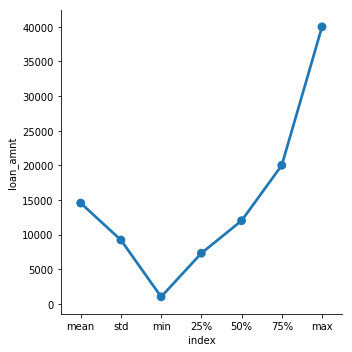

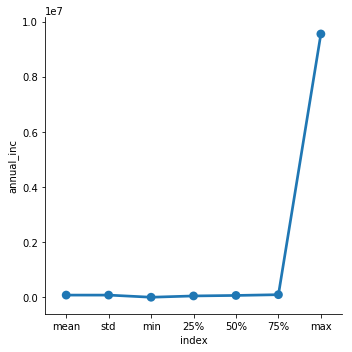

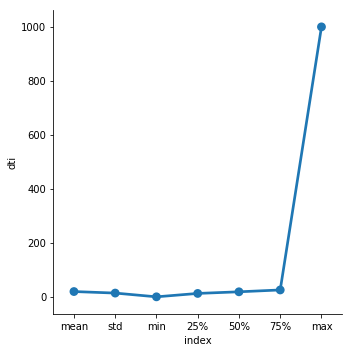

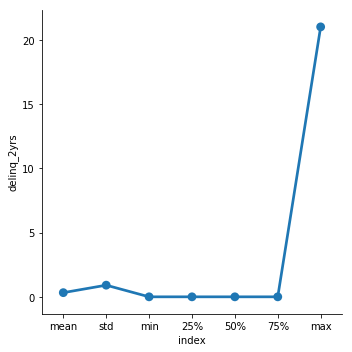

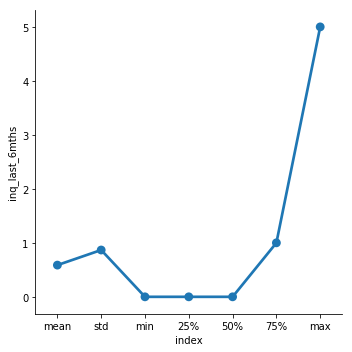

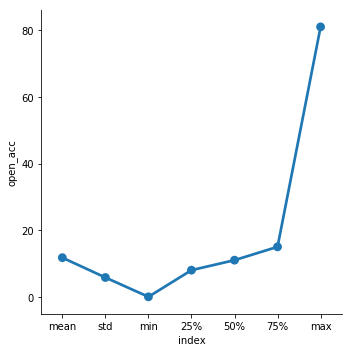

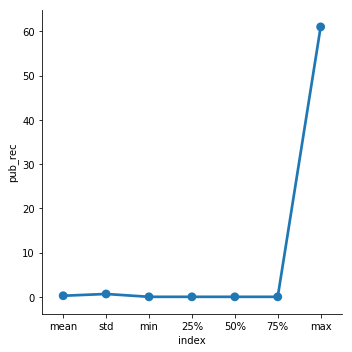

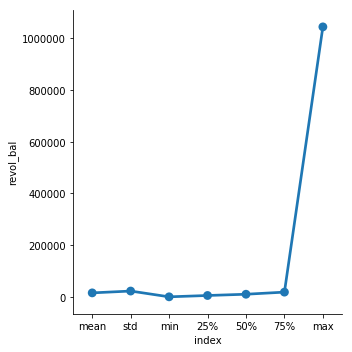

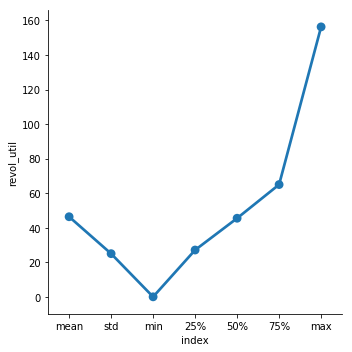

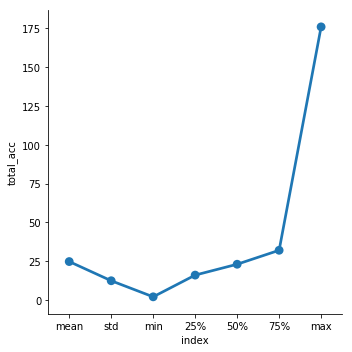

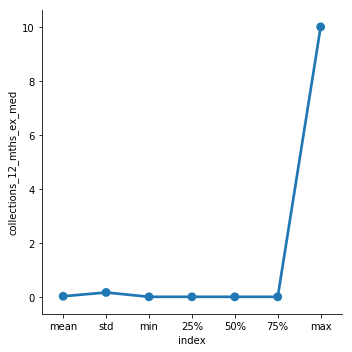

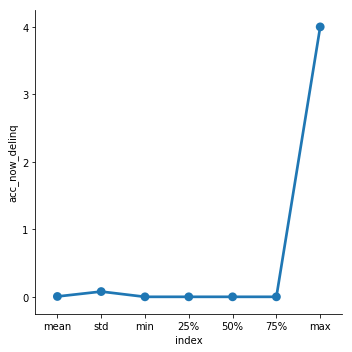

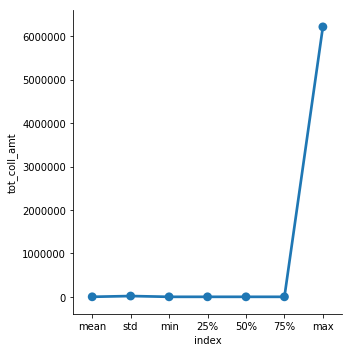

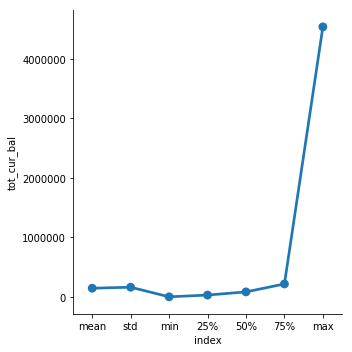

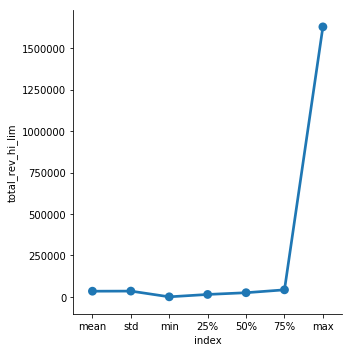

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

describe_num_df = train_data.describe(include=['int64','float64'])

describe_num_df.reset_index(inplace=True)

describe_num_df = describe_num_df[describe_num_df['index'] != 'count']

for i in numerical_variables:
    if i in ['index']:
        continue
    sns.factorplot(x='index', y=i, data=describe_num_df)
    plt.show()

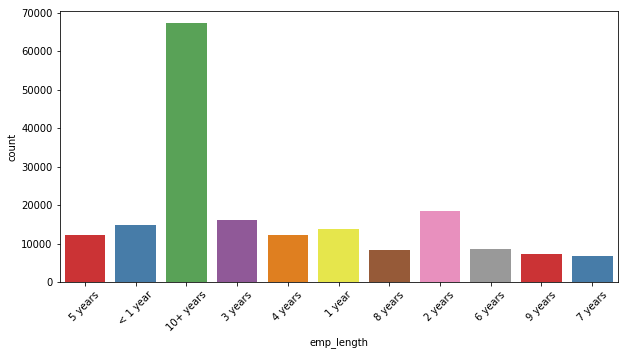

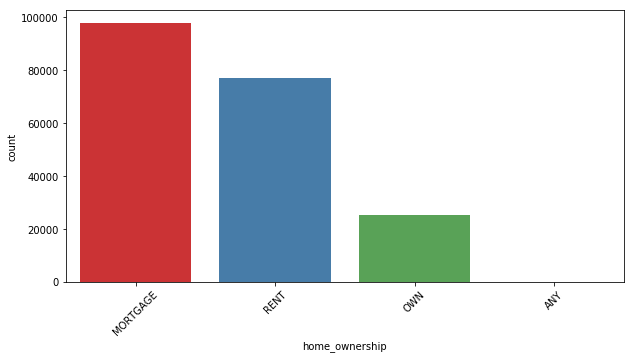

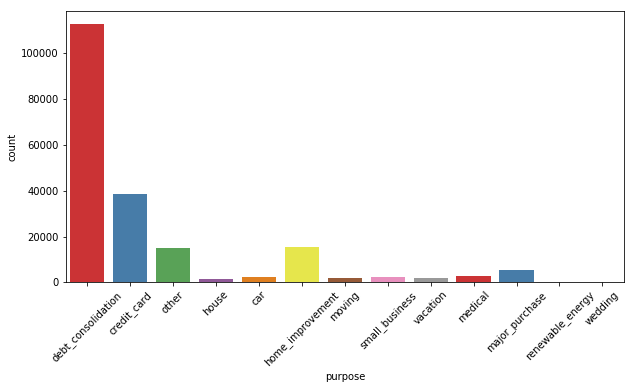

In [18]:
for i in categorical_variables:
    if i in ['source']:
        continue
    plt.figure(figsize=(10, 5))
    chart = sns.countplot(
    data=train_data,
    x=i,
    palette='Set1'
  )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.show()